In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [20]:
df = pd.read_csv('mined_preview.csv')

In [21]:
df.head(10)

,title,url,description_source,description,meta_description,og_description,twitter_description,body_snippet,html_length,content_type
0,@lc-holy - Miraculous & Spy x Family AUs,https://www.tumblr.com/lc-holy,meta,French artist | You can repost/translate my c...,French artist | You can repost/translate my c...,French artist | You can repost/translate my c...,NaN,Explore Communities Change palette Sign up Log...,556703,text/html; charset=utf-8
1,9anime - Watch Anime online with DUB and SUB f...,https://9animetv.to/,meta,9anime is the best free anime streaming websit...,9anime is the best free anime streaming websit...,9anime is the best free anime streaming websit...,NaN,Home Genres Action Adventure Cars Comedy Demen...,95718,text/html; charset=utf-8
2,A Practical Guide to Building Agents,https://cdn.openai.com/business-guides-and-res...,non_html,NaN,NaN,NaN,NaN,NaN,6955858,application/pdf
3,AI Automation Agency Playbook,https://1to10x.ai/wp-content/uploads/2025/06/A...,non_html,NaN,NaN,NaN,NaN,NaN,42330939,application/pdf
4,AI Skills 4 Women Handbook,file:///C:/Users/hp/Downloads/AI%20SKILLS%204%...,unknown,NaN,NaN,NaN,NaN,NaN,0,NaN
5,Alison,https://alison.com/,meta,Free online courses with certificates. Join 15...,Free online courses with certificates. Join 15...,Free online courses with certificates. Join 15...,Free online courses with certificates. Join 15...,Select Site Language English Spanish End of Oc...,191616,text/html; charset=utf-8
6,Anaconda,https://learning.anaconda.com/collections,body,Skip to main content Anaconda Learning Toggle ...,NaN,NaN,NaN,Skip to main content Anaconda Learning Toggle ...,3013962,text/html; charset=utf-8
7,Anaconda Learning,https://learning.anaconda.com/collections,body,Skip to main content Anaconda Learning Toggle ...,NaN,NaN,NaN,Skip to main content Anaconda Learning Toggle ...,3013962,text/html; charset=utf-8
8,Anara | Trustworthy Research Platform,https://anara.com/,meta,Automate your research workflows with Anara's ...,Automate your research workflows with Anara's ...,NaN,NaN,Use cases Resources Pricing Careers Contact sa...,169534,text/html; charset=utf-8
9,Anime,https://hianime.to/,meta,HiAnime is a Free anime streaming website whic...,HiAnime is a Free anime streaming website whic...,HiAnime is a Free anime streaming website whic...,NaN,Menu Home Movies TV Series Most Popular Top Ai...,86395,text/html; charset=utf-8


In [22]:
# Basic stats
print(f"Total bookmarks: {len(df)}")
print(f"\nDescription sources:")
print(df['description_source'].value_counts())

# Check missing values
print(f"\nMissing descriptions: {df['description'].isna().sum()}")
print(f"Empty descriptions: {(df['description'].str.strip() == '').sum()}")

# Content type distribution
print(f"\nContent types:")
print(df['content_type'].value_counts())

Total bookmarks: 256

Description sources:
description_source
meta        159
unknown      53
body         23
non_html     11
og            9
twitter       1
Name: count, dtype: int64

Missing descriptions: 64
Empty descriptions: 0

Content types:
content_type
text/html; charset=utf-8    180
text/html                    21
application/pdf               8
text/html;charset=utf-8       6
image/png                     2
video/mp4                     1
Name: count, dtype: int64


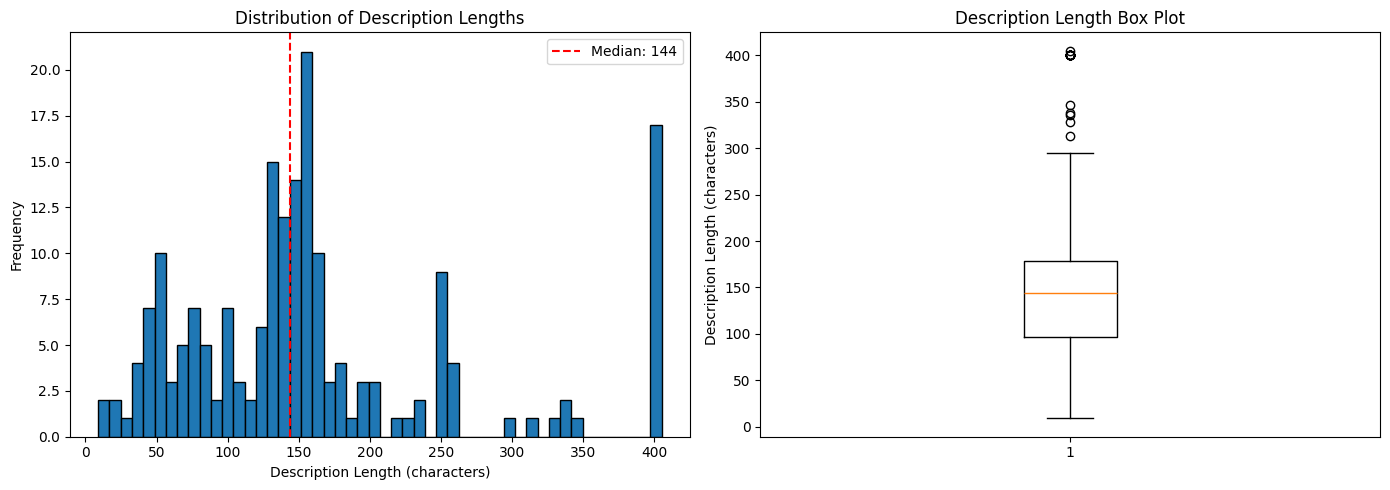

Mean length: 161
Median length: 144
Min length: 9
Max length: 405


In [23]:
df_clean = df[df['description'].notna() & (df['description'].str.strip() != '')].copy()

# Calculate description length
df_clean['desc_length'] = df_clean['description'].str.len()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_clean['desc_length'], bins=50, edgecolor='black')
axes[0].set_xlabel('Description Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Description Lengths')
axes[0].axvline(df_clean['desc_length'].median(), color='red', linestyle='--', label=f'Median: {df_clean["desc_length"].median():.0f}')
axes[0].legend()

# Box plot
axes[1].boxplot(df_clean['desc_length'])
axes[1].set_ylabel('Description Length (characters)')
axes[1].set_title('Description Length Box Plot')

plt.tight_layout()
plt.show()

# Print stats
print(f"Mean length: {df_clean['desc_length'].mean():.0f}")
print(f"Median length: {df_clean['desc_length'].median():.0f}")
print(f"Min length: {df_clean['desc_length'].min()}")
print(f"Max length: {df_clean['desc_length'].max()}")

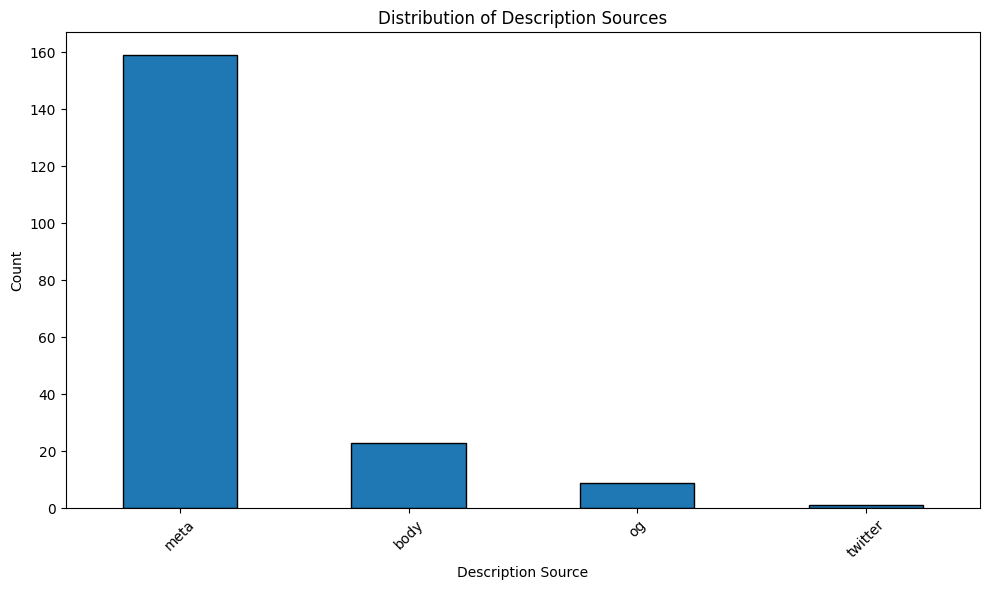

description_source
meta       159
body        23
og           9
twitter      1
Name: count, dtype: int64


In [24]:
# Count by source
source_counts = df_clean['description_source'].value_counts()

plt.figure(figsize=(10, 6))
source_counts.plot(kind='bar', edgecolor='black')
plt.xlabel('Description Source')
plt.ylabel('Count')
plt.title('Distribution of Description Sources')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(source_counts)

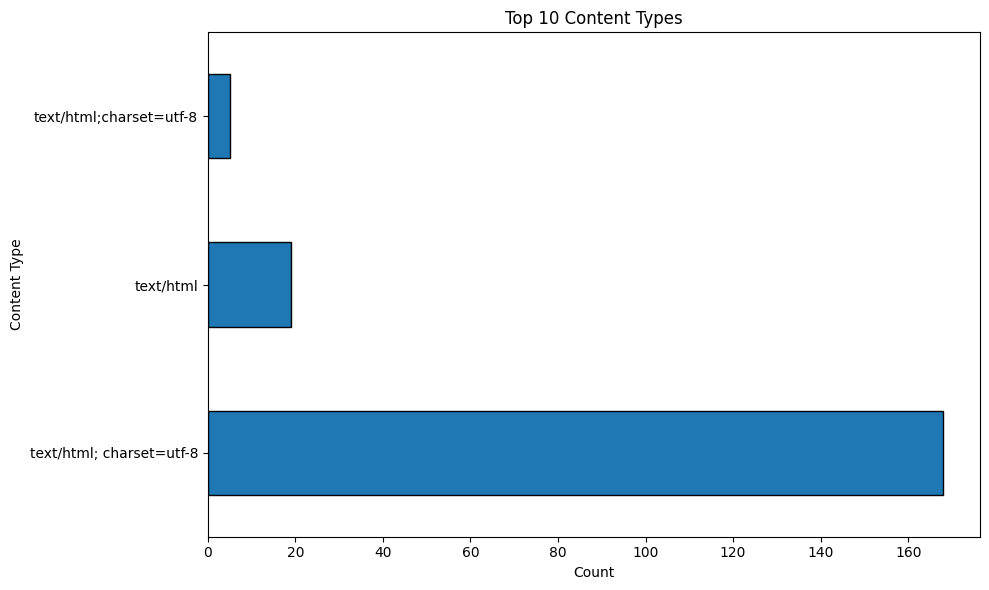

HTML content: 192
Non-HTML content: 0


In [25]:
# Filter out non-HTML
content_types = df_clean['content_type'].value_counts()

plt.figure(figsize=(10, 6))
content_types.head(10).plot(kind='barh', edgecolor='black')
plt.xlabel('Count')
plt.ylabel('Content Type')
plt.title('Top 10 Content Types')
plt.tight_layout()
plt.show()

print(f"HTML content: {(df_clean['content_type'].str.contains('html', case=False, na=False)).sum()}")
print(f"Non-HTML content: {(~df_clean['content_type'].str.contains('html', case=False, na=False)).sum()}")

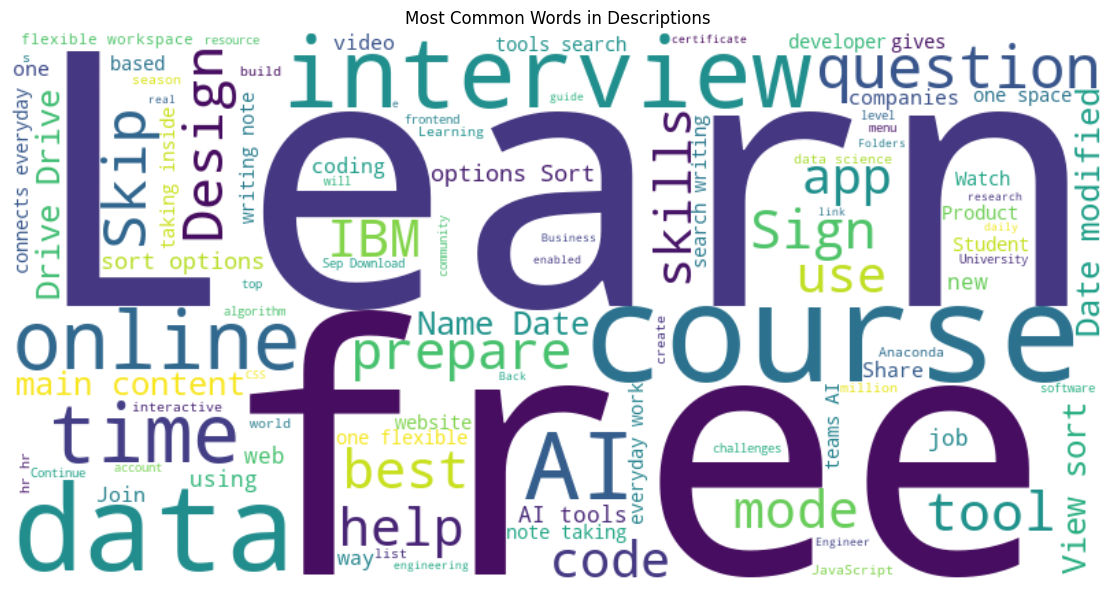

In [26]:
# Combine all descriptions
all_text = ' '.join(df_clean['description'].astype(str))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', 
                      max_words=100, colormap='viridis').generate(all_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Descriptions')
plt.tight_layout()
plt.show()

In [27]:
# Sample short, medium, and long descriptions
short_sample = df_clean.nsmallest(5, 'desc_length')[['title', 'description', 'desc_length']]
long_sample = df_clean.nlargest(5, 'desc_length')[['title', 'description', 'desc_length']]

print("=== SHORTEST DESCRIPTIONS ===")
for idx, row in short_sample.iterrows():
    print(f"\nTitle: {row['title']}")
    print(f"Length: {row['desc_length']}")
    print(f"Description: {row['description'][:200]}")

print("\n\n=== LONGEST DESCRIPTIONS ===")
for idx, row in long_sample.iterrows():
    print(f"\nTitle: {row['title']}")
    print(f"Length: {row['desc_length']}")
    print(f"Description: {row['description'][:200]}...")

=== SHORTEST DESCRIPTIONS ===

Title: Play Hamilton Original Broadway Cast (Amazon Music Track by Track) by Lin-Manuel Miranda on Amazon Music Unlimited
Length: 9
Description: Tuning in

Title: Jake's Notes - Iteration vs Recursion
Length: 12
Description: Jake's Notes

Title: Link - Phi Kappa Phi
Length: 18
Description: The site home page

Title: freeCodeCamp.org
Length: 24
Description: Learn to Code — For Free

Title: Udemy
Length: 27
Description: LibGuides: Gale Udemy: Home


=== LONGEST DESCRIPTIONS ===

Title: Welcome - University Ombuds
Length: 405
Description: The University Ombuds program at UNC Charlotte is a confidential, independent, impartial, and informal resource for faculty, staff, and students (graduate and undergraduate) to informally work through...

Title: Anaconda
Length: 400
Description: Skip to main content Anaconda Learning Toggle menu Menu Back to anaconda.com <  Back to anaconda.com Course Catalog Sign In Products 1-2 hr <1 hr 2-3 hr 3-4 hr >4 hr AI / Machine Le

In [28]:
# Combined cleaning pipeline
df = pd.read_csv('mined_preview.csv')

df_clean = df[
    df['description'].notna() &
    (df['description'].str.strip() != '') &
    ~df['description_source'].isin(['unknown', 'non_html'])
].copy()

df_clean['desc_length'] = df_clean['description'].str.len()
df_clean = df_clean[df_clean['desc_length'] >= 30].copy()

# Save cleaned data
df_clean.to_csv('bookmarks_cleaned.csv', index=False)

print(f"\n=== FINAL CLEANED DATASET ===")
print(f"Total bookmarks: {len(df_clean)}")
print(f"Removed: {256 - len(df_clean)} bookmarks ({100 * (256 - len(df_clean)) / 256:.1f}%)")
print(f"\nDescription length stats:")
print(df_clean['desc_length'].describe())
print(f"\nDescription sources:")
print(df_clean['description_source'].value_counts())


=== FINAL CLEANED DATASET ===
Total bookmarks: 187
Removed: 69 bookmarks (27.0%)

Description length stats:
count    187.000000
mean     165.069519
std       97.779819
min       33.000000
25%      102.500000
50%      145.000000
75%      183.500000
max      405.000000
Name: desc_length, dtype: float64

Description sources:
description_source
meta    157
body     22
og        8
Name: count, dtype: int64


In [29]:
# Load cleaned data
df_clean = pd.read_csv('bookmarks_cleaned.csv')

print(f"Creating embeddings for {len(df_clean)} bookmarks...")

# Initialize sentence transformer
model = SentenceTransformer("all-MiniLM-L6-v2")

# Create embeddings from descriptions
embeddings = model.encode(df_clean['description'].tolist(), show_progress_bar=True)

print(f"Embeddings shape: {embeddings.shape}")
print(f"Each bookmark is represented as a {embeddings.shape[1]}-dimensional vector")

Creating embeddings for 187 bookmarks...


Batches: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]

Embeddings shape: (187, 384)
Each bookmark is represented as a 384-dimensional vector


In [34]:
# Test different values of N
n_values = [5, 8, 10, 12, 15, 20]
metrics_results = {
    'n_clusters': [],
    'silhouette': [],
    'davies_bouldin': [],
    'calinski_harabasz': [],
    'avg_cluster_size': [],
    'min_cluster_size': [],
    'max_cluster_size': []
}

for n in n_values:
    print(f"\nTesting N={n}...")
    
    # Perform clustering
    clustering = AgglomerativeClustering(n_clusters=n, linkage='ward')
    labels = clustering.fit_predict(embeddings)
    
    # Calculate metrics
    sil_score = silhouette_score(embeddings, labels)
    db_score = davies_bouldin_score(embeddings, labels)
    ch_score = calinski_harabasz_score(embeddings, labels)
    
    # Calculate cluster sizes
    unique, counts = np.unique(labels, return_counts=True)
    avg_size = np.mean(counts)
    min_size = np.min(counts)
    max_size = np.max(counts)
    
    # Store results
    metrics_results['n_clusters'].append(n)
    metrics_results['silhouette'].append(sil_score)
    metrics_results['davies_bouldin'].append(db_score)
    metrics_results['calinski_harabasz'].append(ch_score)
    metrics_results['avg_cluster_size'].append(avg_size)
    metrics_results['min_cluster_size'].append(min_size)
    metrics_results['max_cluster_size'].append(max_size)
    
    print(f"  Silhouette: {sil_score:.3f} (higher is better)")
    print(f"  Davies-Bouldin: {db_score:.3f} (lower is better)")
    print(f"  Calinski-Harabasz: {ch_score:.1f} (higher is better)")
    print(f"  Avg cluster size: {avg_size:.1f} bookmarks")
    print(f"  Size range: {min_size} to {max_size} bookmarks")

# Convert to DataFrame for easy analysis
metrics_df = pd.DataFrame(metrics_results)
print("\n=== Summary of All Metrics ===")
print(metrics_df)


Testing N=5...
  Silhouette: 0.065 (higher is better)
  Davies-Bouldin: 3.241 (lower is better)
  Calinski-Harabasz: 7.9 (higher is better)
  Avg cluster size: 37.4 bookmarks
  Size range: 6 to 74 bookmarks

Testing N=8...
  Silhouette: 0.096 (higher is better)
  Davies-Bouldin: 2.584 (lower is better)
  Calinski-Harabasz: 7.2 (higher is better)
  Avg cluster size: 23.4 bookmarks
  Size range: 5 to 69 bookmarks

Testing N=10...
  Silhouette: 0.109 (higher is better)
  Davies-Bouldin: 2.610 (lower is better)
  Calinski-Harabasz: 6.7 (higher is better)
  Avg cluster size: 18.7 bookmarks
  Size range: 5 to 58 bookmarks

Testing N=12...
  Silhouette: 0.123 (higher is better)
  Davies-Bouldin: 2.437 (lower is better)
  Calinski-Harabasz: 6.3 (higher is better)
  Avg cluster size: 15.6 bookmarks
  Size range: 4 to 58 bookmarks

Testing N=15...
  Silhouette: 0.133 (higher is better)
  Davies-Bouldin: 2.598 (lower is better)
  Calinski-Harabasz: 5.9 (higher is better)
  Avg cluster size: 12.5

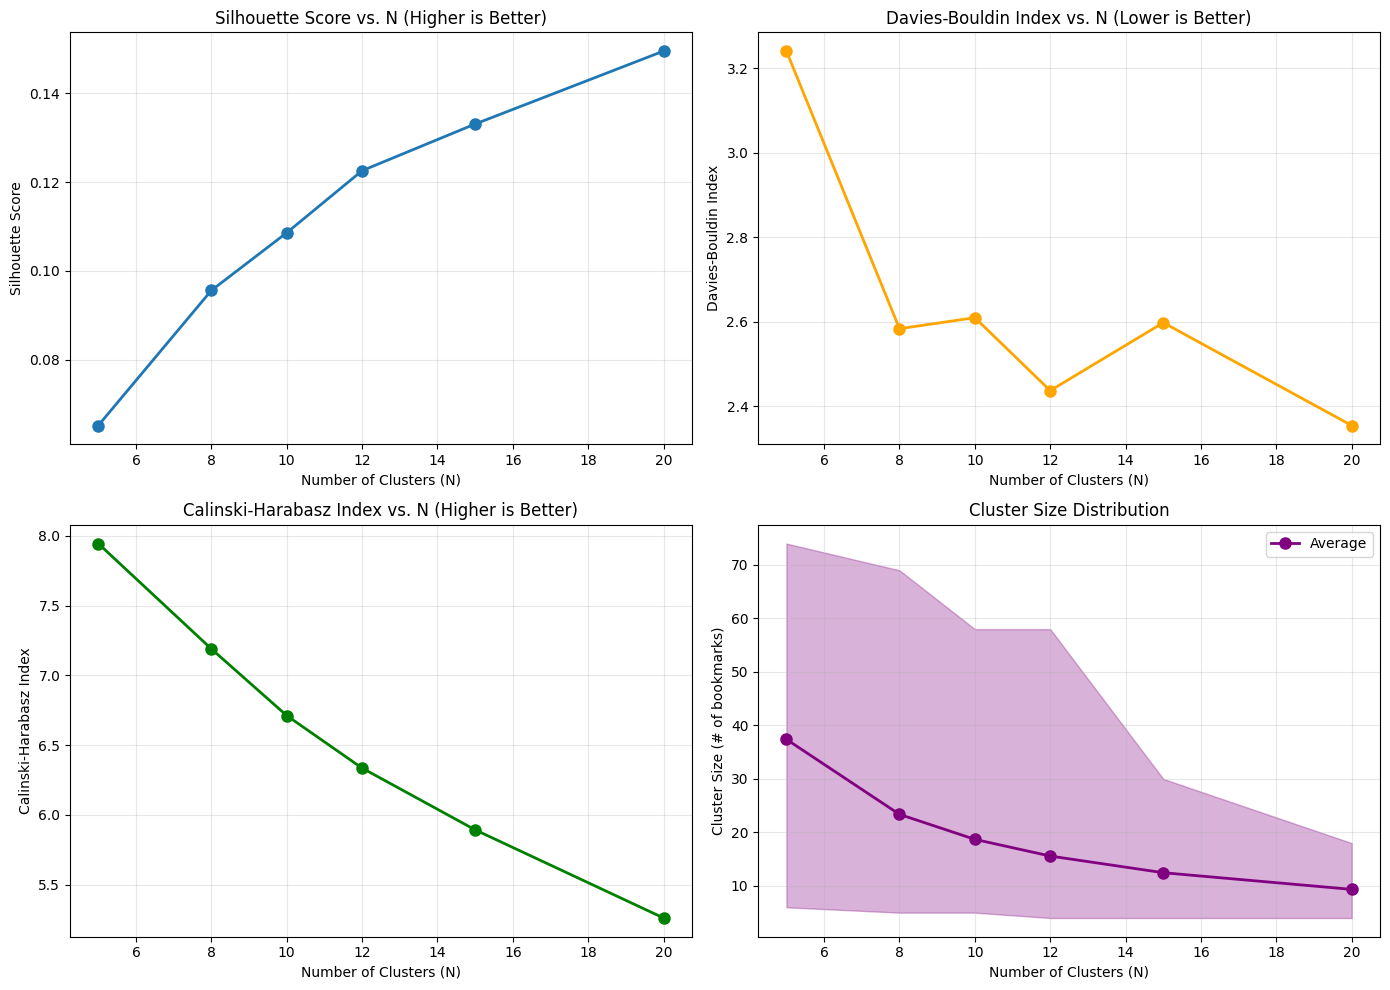

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Silhouette Score (higher is better)
axes[0, 0].plot(metrics_df['n_clusters'], metrics_df['silhouette'], 
                marker='o', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (N)')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('Silhouette Score vs. N (Higher is Better)')
axes[0, 0].grid(True, alpha=0.3)

# Davies-Bouldin Index (lower is better)
axes[0, 1].plot(metrics_df['n_clusters'], metrics_df['davies_bouldin'], 
                marker='o', linewidth=2, markersize=8, color='orange')
axes[0, 1].set_xlabel('Number of Clusters (N)')
axes[0, 1].set_ylabel('Davies-Bouldin Index')
axes[0, 1].set_title('Davies-Bouldin Index vs. N (Lower is Better)')
axes[0, 1].grid(True, alpha=0.3)

# Calinski-Harabasz Index (higher is better)
axes[1, 0].plot(metrics_df['n_clusters'], metrics_df['calinski_harabasz'], 
                marker='o', linewidth=2, markersize=8, color='green')
axes[1, 0].set_xlabel('Number of Clusters (N)')
axes[1, 0].set_ylabel('Calinski-Harabasz Index')
axes[1, 0].set_title('Calinski-Harabasz Index vs. N (Higher is Better)')
axes[1, 0].grid(True, alpha=0.3)

# Cluster Size Distribution
axes[1, 1].plot(metrics_df['n_clusters'], metrics_df['avg_cluster_size'], 
                marker='o', linewidth=2, markersize=8, label='Average', color='purple')
axes[1, 1].fill_between(metrics_df['n_clusters'], 
                         metrics_df['min_cluster_size'], 
                         metrics_df['max_cluster_size'], 
                         alpha=0.3, color='purple')
axes[1, 1].set_xlabel('Number of Clusters (N)')
axes[1, 1].set_ylabel('Cluster Size (# of bookmarks)')
axes[1, 1].set_title('Cluster Size Distribution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('clustering_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

In [39]:
# Load data and create embeddings (you already have this)
df_clean = pd.read_csv('bookmarks_cleaned.csv')
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(df_clean['description'].tolist())

# Final clustering with N=12
optimal_n = 10
clustering = AgglomerativeClustering(n_clusters=optimal_n, linkage='ward')
labels = clustering.fit_predict(embeddings)

# Add cluster labels to dataframe
df_clean['cluster'] = labels

# Analyze each cluster
print(f"=== CLUSTER ANALYSIS (N={optimal_n}) ===\n")
for cluster_id in range(optimal_n):
    cluster_df = df_clean[df_clean['cluster'] == cluster_id]
    print(f"\n--- Cluster {cluster_id} ({len(cluster_df)} bookmarks) ---")
    print("Sample titles:")
    for title in cluster_df['title'].head(5):
        print(f"  • {title[:80]}")

=== CLUSTER ANALYSIS (N=10) ===


--- Cluster 0 (20 bookmarks) ---
Sample titles:
  • ascherj/neetcode-250-guide
  • Blind75
  • DSA Handbook and Cheatsheets
  • Frontend Behavioral Interview Questions | FrontendLead
  • Frontend System Design Fundamentals (All In One Guide)

--- Cluster 1 (30 bookmarks) ---
Sample titles:
  • Alison
  • Be There Certificate
  • Behavorial Interview Worksheet
  • Career Center - Skill Pathways Program | Coursera
  • Career Center / Hire-A-Niner

--- Cluster 2 (20 bookmarks) ---
Sample titles:
  • Anara | Trustworthy Research Platform
  • CiteSnap
  • DeepLearning.AI
  • Explore All Free AI Content Generator Tools | Saze AI
  • Feedough - Product Requirements Document (PRD) Generator

--- Cluster 3 (15 bookmarks) ---
Sample titles:
  • Anaconda
  • Anaconda Learning
  • Big-O Algorithm Complexity Cheat Sheet
  • Binary Search Tree - Node Insertion & Removal
  • Codédex

--- Cluster 4 (58 bookmarks) ---
Sample titles:
  • Beautiful themes for shadcn/ui —

In [40]:
# Examine Cluster 0 in detail
cluster_0 = df_clean[df_clean['cluster'] == 0].copy()

print(f"=== CLUSTER 0 DEEP DIVE ({len(cluster_0)} bookmarks, N = {optimal_n}) ===\n")

# Look at all titles
print("All titles in Cluster 0:")
for idx, title in enumerate(cluster_0['title'].values, 1):
    print(f"{idx:2d}. {title[:80]}")

# Check if there are sub-themes
print("\n\nDescription word frequency:")
from collections import Counter
all_words = ' '.join(cluster_0['description'].values).lower().split()
common_words = Counter(all_words).most_common(20)
print(common_words)

=== CLUSTER 0 DEEP DIVE (20 bookmarks, N = 10) ===

All titles in Cluster 0:
 1. ascherj/neetcode-250-guide
 2. Blind75
 3. DSA Handbook and Cheatsheets
 4. Frontend Behavioral Interview Questions | FrontendLead
 5. Frontend System Design Fundamentals (All In One Guide)
 6. Frontend Trivia Questions | FrontendLead
 7. Interview Question Predictor
 8. Interview Questions from top Tech companies
 9. Interview Questions from Top Tech Companies
10. Interview Warmup
11. LeetCode Company Questions
12. LeetCode Company Questions
13. LeetCode Company-Wise Problems 2022
14. Leetcode Company-Wise Questions
15. Leetcode Company-Wise Questions
16. neetcode.io
17. Preparation Kits
18. Preparation Kits | HackerRank
19. The Front End Interview Handbook - 2025 - FrontendLead
20. Top Javascript/React Coding Interview Questions | FrontendLead


Description word frequency:
[('and', 21), ('for', 21), ('questions', 14), ('with', 14), ('interview', 11), ('of', 10), ('prepare', 9), ('on', 8), ('a', 7), ('lee